In [19]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

Cycled at constant current of 1°C

In [22]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

In [23]:
df_35 = pd.read_csv('datasets/CS2_35.csv',index_col=0).dropna()
df_36 = pd.read_csv('datasets/CS2_36.csv',index_col=0).dropna()
df_37 = pd.read_csv('datasets/CS2_37.csv',index_col=0).dropna()
df_38 = pd.read_csv('datasets/CS2_38.csv',index_col=0).dropna()

In [24]:
Battery = {}
Battery['CS2_35'] = df_35
Battery['CS2_36'] = df_36
Battery['CS2_37'] = df_37
Battery['CS2_38'] = df_38

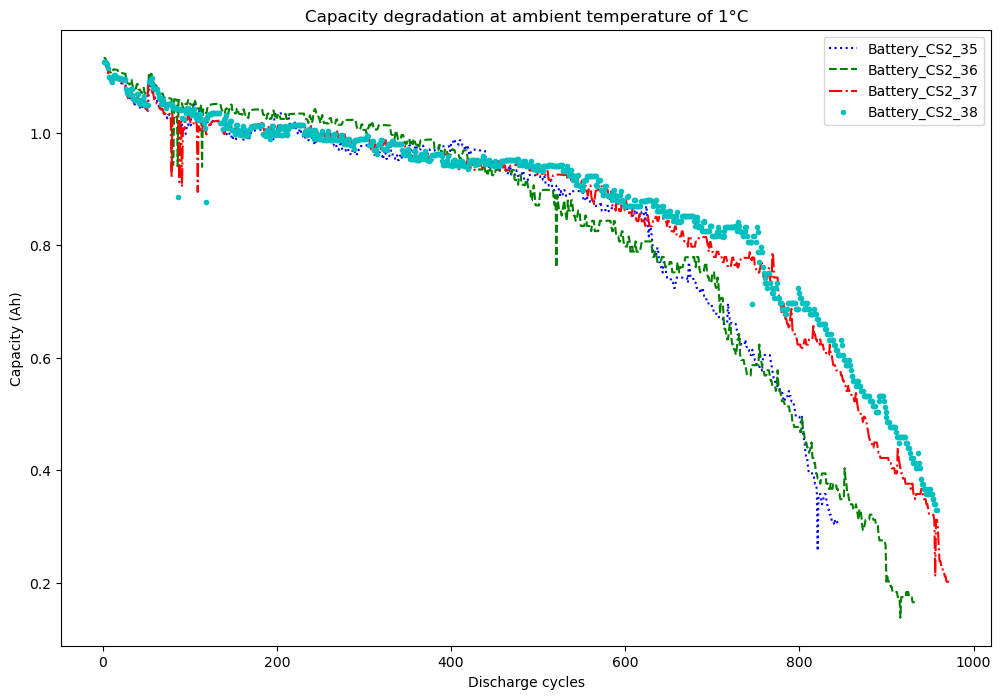

In [25]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
#plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # critical line
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [26]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# Leave-one-out evaluation: one set of data is the test set, and all other data are used for training
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re    
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # In order to prohibit hash randomization, the experiment can be reproduced.
    torch.manual_seed(seed) # Set random seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # Set random seed for current GPU
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，Set random seed for all GPUs
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [27]:
class Net(nn.Module):
    def __init__(self, feature_size=8, hidden_size=[16, 8]):
        super(Net, self).__init__()
        self.feature_size, self.hidden_size = feature_size, hidden_size
        self.layer0 = nn.Linear(self.feature_size, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) 
                       for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        out = self.layer0(x)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out

# leave one out

In [28]:
def tain(LR=0.01, feature_size=8, hidden_size=[16,8], weight_decay=0.0, window_size=8, EPOCH=1000, seed=0):
    mae_list, rmse_list, re_list = [], [], []
    result_list = []
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(feature_size=feature_size, hidden_size=hidden_size)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity, (-1, feature_size)).astype(np.float32)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output= model(X)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy() #Re-predict every 100
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity, (-1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    pred = model(x) # Test set Model predictions #pred shape为(batch_size=1, feature_size=1)
                    next_point = pred.data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)#The test value is added to the original sequence to continue predicting the next point
                    point_list.append(next_point)#save the predicted value for the last point of the output sequence
                y_.append(point_list)#Save all forecast values for this forecast
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(
                    y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            if (len(loss_list) > 1) and (abs(loss_list[-2] - loss_list[-1]) < 1e-6):
                break

        mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
        re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
        mae_list.append(mae)
        rmse_list.append(rmse)
        re_list.append(re)
        result_list.append(y_[-1])
    return re_list, mae_list, rmse_list, result_list

# Set 10 different random seeds and take the average.

In [29]:
window_size = 8
EPOCH = 1000
LR = 0.01    # learning rate
feature_size = window_size
hidden_size = [32,16]
weight_decay = 0.0
Rated_Capacity = 1.1

MAE, RMSE, RE = [], [], []
for seed in range(10):
    re_list, mae_list, rmse_list, _ = tain(LR=LR, feature_size=feature_size, hidden_size=hidden_size, weight_decay=weight_decay,
                                           window_size=window_size, EPOCH=EPOCH, seed=seed)
    RE.append(np.mean(np.array(re_list)))
    MAE.append(np.mean(np.array(mae_list)))
    RMSE.append(np.mean(np.array(rmse_list)))
    print('------------------------------------------------------------------')

print('RE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RE)), np.std(np.array(RE))))
print('MAE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(MAE)), np.std(np.array(MAE))))
print('RMSE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RMSE)), np.std(np.array(RMSE))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

sample size: 2807
epoch:99 | loss:0.0002 | MAE:0.1633 | RMSE:0.1825 | RE:0.5871
epoch:199 | loss:0.0001 | MAE:0.0410 | RMSE:0.0482 | RE:0.0629
epoch:299 | loss:0.0001 | MAE:0.0413 | RMSE:0.0487 | RE:0.0645
sample size: 2715
epoch:99 | loss:0.0004 | MAE:0.1865 | RMSE:0.2508 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0637 | RMSE:0.0870 | RE:0.1017
epoch:299 | loss:0.0001 | MAE:0.0847 | RMSE:0.1158 | RE:0.1463
sample size: 2680
epoch:99 | loss:0.0003 | MAE:0.1503 | RMSE:0.1870 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.1409 | RMSE:0.1949 | RE:0.2123
epoch:299 | loss:0.0001 | MAE:0.1409 | RMSE:0.1960 | RE:0.2095
sample size: 2689
epoch:99 | loss:0.0002 | MAE:0.1563 | RMSE:0.1716 | RE:0.5865
epoch:199 | loss:0.0001 | MAE:0.1511 | RMSE:0.2169 | RE:0.2432
epoch:299 | loss:0.0001 | MAE:0.1489 | RMSE:0.2143 | RE:0.2405
------------------------------------------------------------------
sample size: 2807
epoch:99 | loss:0.0015 | MAE:0.1331 | RMSE:0.1804 | RE:1.0000
epoch:199 | loss:0.0003 | MAE

epoch:499 | loss:0.0001 | MAE:0.0598 | RMSE:0.0779 | RE:0.0903
epoch:599 | loss:0.0001 | MAE:0.1214 | RMSE:0.1501 | RE:0.2806
sample size: 2715
epoch:99 | loss:0.0003 | MAE:0.1760 | RMSE:0.2631 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.1606 | RMSE:0.2095 | RE:0.1304
epoch:299 | loss:0.0001 | MAE:0.1115 | RMSE:0.1299 | RE:0.2973
epoch:399 | loss:0.0001 | MAE:0.0357 | RMSE:0.0472 | RE:0.0572
epoch:499 | loss:0.0001 | MAE:0.2697 | RMSE:0.3565 | RE:1.0000
epoch:599 | loss:0.0001 | MAE:0.4759 | RMSE:0.6479 | RE:1.0000
sample size: 2680
epoch:99 | loss:0.0003 | MAE:0.1307 | RMSE:0.2068 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.1345 | RMSE:0.1620 | RE:0.3572
epoch:299 | loss:0.0001 | MAE:0.1310 | RMSE:0.1564 | RE:0.3931
epoch:399 | loss:0.0001 | MAE:0.1423 | RMSE:0.1800 | RE:0.2740
epoch:499 | loss:0.0001 | MAE:0.0780 | RMSE:0.0965 | RE:0.1277
epoch:599 | loss:0.0001 | MAE:0.0453 | RMSE:0.0517 | RE:0.0143
sample size: 2689
epoch:99 | loss:0.0003 | MAE:0.1097 | RMSE:0.1661 | RE:1.0000
epoc

# View the curve fitting effect of each battery group

In [30]:
# seed = 6
# _, _, _, result_list = tain(LR=LR, feature_size=feature_size, hidden_size=hidden_size, weight_decay=weight_decay,
#                             window_size=window_size, EPOCH=EPOCH, seed=seed)
# for i in range(4):
#     name = Battery_list[i]
#     train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)

#     aa = train_data[:window_size+1].copy() # first input sequence
#     [aa.append(a) for a in result_list[i]] # Test set prediction results

#     battery = Battery[name]
#     fig, ax = plt.subplots(1, figsize=(12, 8))
#     ax.plot(battery['cycle'], battery['capacity'], 'b.', label=name)
#     ax.plot(battery['cycle'], aa, 'r.', label='Prediction')
#     plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # critical line
#     ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
#     plt.legend()